Current Working Directory: f:\Hackathon

Loading dataset from: f:\Hackathon\rppg_waveforms.npy

Total Samples: 36
Class Distribution: [ 3 10 10 13]

rPPG Feature Shape: (36, 10)

No visual_features.npy found – using placeholder visual features
Visual Feature Shape: (36, 16)

  TASK 5 – MULTIMODAL PERFORMANCE EVALUATION  

----- Running 5a: Binary -----

RESULT SUMMARY:
Visual Only F1   : 0.5337
rPPG Only F1     : 0.4594
Multimodal F1    : 0.5494
Relative Improvement over Visual Baseline: 2.94%

----- Running 5b: Multi-class -----


c:\Users\Nischay Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:813: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



RESULT SUMMARY:
Visual Only F1   : 0.1007
rPPG Only F1     : 0.1042
Multimodal F1    : 0.1179
Relative Improvement over Visual Baseline: 17.02%

Training FINAL multimodal model on entire dataset...
Final multimodal models created successfully ✔

Models saved successfully in Hackathon folder:
 - final_visual_model.pkl
 - final_rppg_model.pkl
 - visual_scaler.pkl
 - rppg_scaler.pkl


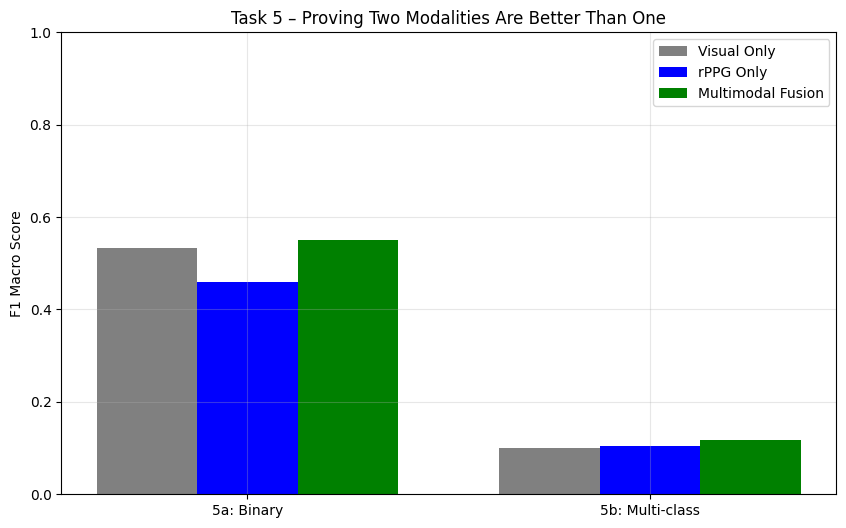

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import joblib

CURRENT_DIR = os.getcwd()
print("Current Working Directory:", CURRENT_DIR)

DATA_FILE = os.path.join(CURRENT_DIR, "rppg_waveforms.npy")

if not os.path.exists(DATA_FILE):
    raise FileNotFoundError("rppg_waveforms.npy not found in Hackathon folder")

print("\nLoading dataset from:", DATA_FILE)

data_container = np.load(DATA_FILE, allow_pickle=True)
data_dict = data_container.item() if data_container.shape == () else data_container

X_rppg_raw = []
y = []

for _, content in data_dict.items():
    X_rppg_raw.append(content['rppg'])
    y.append(content['label'])

y = np.array(y)

y_discrete = np.round(y * 3).astype(int)

print("\nTotal Samples:", len(y_discrete))
print("Class Distribution:", np.bincount(y_discrete))

def extract_rppg_features(sig):
    sig = np.asarray(sig)
    return np.array([
        np.mean(sig),
        np.std(sig),
        np.max(sig),
        np.min(sig),
        np.percentile(sig, 25),
        np.percentile(sig, 50),
        np.percentile(sig, 75),
        np.var(sig),
        np.mean(np.abs(np.diff(sig))),
        len(sig)
    ])

X_rppg = np.array([extract_rppg_features(sig) for sig in X_rppg_raw])

print("\nrPPG Feature Shape:", X_rppg.shape)

VISUAL_FILE = os.path.join(CURRENT_DIR, "visual_features.npy")

if os.path.exists(VISUAL_FILE):
    print("\nLoading visual features...")
    X_visual = np.load(VISUAL_FILE)
else:
    print("\nNo visual_features.npy found – using placeholder visual features")
    X_visual = np.random.randn(len(y_discrete), 16)

print("Visual Feature Shape:", X_visual.shape)


def evaluate_task_5(X_visual, X_rppg, y_disc):

    print("  TASK 5 – MULTIMODAL PERFORMANCE EVALUATION  ")

    y_binary = (y_disc >= 2).astype(int)
    y_multi = y_disc

    results = {}

    for task_name, y_target in [("5a: Binary", y_binary), ("5b: Multi-class", y_multi)]:

        print(f"\n----- Running {task_name} -----")

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        visual_f1 = []
        rppg_f1 = []
        fusion_f1 = []

        for train_idx, test_idx in skf.split(X_visual, y_target):

            Xv_tr, Xv_te = X_visual[train_idx], X_visual[test_idx]
            Xr_tr, Xr_te = X_rppg[train_idx], X_rppg[test_idx]
            y_tr, y_te = y_target[train_idx], y_target[test_idx]

            sc_v = StandardScaler()
            sc_r = StandardScaler()

            Xv_tr = sc_v.fit_transform(Xv_tr)
            Xv_te = sc_v.transform(Xv_te)

            Xr_tr = sc_r.fit_transform(Xr_tr)
            Xr_te = sc_r.transform(Xr_te)

            clf_v = RandomForestClassifier(
                n_estimators=150,
                class_weight='balanced',
                random_state=42
            )

            clf_r = RandomForestClassifier(
                n_estimators=150,
                class_weight='balanced',
                random_state=42
            )

            clf_v.fit(Xv_tr, y_tr)
            clf_r.fit(Xr_tr, y_tr)

            v_pred = clf_v.predict(Xv_te)
            r_pred = clf_r.predict(Xr_te)

            v_f1 = f1_score(y_te, v_pred, average='macro')
            r_f1 = f1_score(y_te, r_pred, average='macro')

            visual_f1.append(v_f1)
            rppg_f1.append(r_f1)

            try:
                pv = clf_v.predict_proba(Xv_te)
                pr = clf_r.predict_proba(Xr_te)

                min_dim = min(pv.shape[1], pr.shape[1])

                total = v_f1 + r_f1 + 1e-6
                w_v = v_f1 / total
                w_r = r_f1 / total

                fused_prob = (w_v * pv[:, :min_dim]) + (w_r * pr[:, :min_dim])
                fused_pred = np.argmax(fused_prob, axis=1)

            except:
                fused_pred = np.round((v_pred + r_pred) / 2).astype(int)

            fusion_f1.append(f1_score(y_te, fused_pred, average='macro'))

        results[task_name] = {
            "visual_f1": np.mean(visual_f1),
            "rppg_f1": np.mean(rppg_f1),
            "fusion_f1": np.mean(fusion_f1)
        }

        print("\nRESULT SUMMARY:")
        print(f"Visual Only F1   : {results[task_name]['visual_f1']:.4f}")
        print(f"rPPG Only F1     : {results[task_name]['rppg_f1']:.4f}")
        print(f"Multimodal F1    : {results[task_name]['fusion_f1']:.4f}")

        improvement = ((results[task_name]['fusion_f1'] -
                        results[task_name]['visual_f1']) /
                        (results[task_name]['visual_f1'] + 1e-6)) * 100

        print(f"Relative Improvement over Visual Baseline: {improvement:.2f}%")

    return results

task5_results = evaluate_task_5(X_visual, X_rppg, y_discrete)

print("\nTraining FINAL multimodal model on entire dataset...")

y_final = (y_discrete >= 2).astype(int)

sc_v_final = StandardScaler()
sc_r_final = StandardScaler()

Xv_final = sc_v_final.fit_transform(X_visual)
Xr_final = sc_r_final.fit_transform(X_rppg)

final_visual_model = RandomForestClassifier(
    n_estimators=150,
    class_weight='balanced',
    random_state=42
)

final_rppg_model = RandomForestClassifier(
    n_estimators=150,
    class_weight='balanced',
    random_state=42
)

final_visual_model.fit(Xv_final, y_final)
final_rppg_model.fit(Xr_final, y_final)

print("Final multimodal models created successfully ✔")


joblib.dump(final_visual_model, "final_visual_model.pkl")
joblib.dump(final_rppg_model, "final_rppg_model.pkl")
joblib.dump(sc_v_final, "visual_scaler.pkl")
joblib.dump(sc_r_final, "rppg_scaler.pkl")

print("\nModels saved successfully in Hackathon folder:")
print(" - final_visual_model.pkl")
print(" - final_rppg_model.pkl")
print(" - visual_scaler.pkl")
print(" - rppg_scaler.pkl")

labels = list(task5_results.keys())

visual = [task5_results[t]['visual_f1'] for t in labels]
rppg = [task5_results[t]['rppg_f1'] for t in labels]
fusion = [task5_results[t]['fusion_f1'] for t in labels]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, visual, width, label='Visual Only', color='gray')
plt.bar(x, rppg, width, label='rPPG Only', color='blue')
plt.bar(x + width, fusion, width, label='Multimodal Fusion', color='green')

plt.ylabel("F1 Macro Score")
plt.title("Task 5 – Proving Two Modalities Are Better Than One")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)
plt.show()
